# Advancement on Groundouts, DP, and FC
During a play, it is decided whether it will be a groundout, flyout, or hit. This notebook encompasses all of the possibilities after a groundout has been decided.

There are three formulas needed:
```python
df["threshold_advance"] = 0.50 
                        + 0.35 * df[f"runner_on_{base}_indulgence_with_vibe"] 
                        - 0.10 * df["fielder_tenaciousness_with_vibe"] 
                        - 0.10 * (df["ballpark_inconvenience"] - 0.50) 
                        - 0.10 * (df["ballpark_elongation"] - 0.50)
df["threshold_doubleplay"] = -0.05
                            + 0.40 * df["pitcher_shakespearianism_with_vibe"]
                            - 0.18 * df["batter_inv_tragicness"]
                            + 0.10 * df['fielder_tenaciousness_with_vibe']
                            - 0.18 * (df["ballpark_elongation"] - 0.5)

df["threshold_martyr"] = 0.05 
                       + 0.25 * df["batter_martyrdom"]

dfc.loc[dfc["threshold_rounded"] < 0.001, "threshold_rounded"] = 0.001
```


In [2841]:
# Load Dataframe

import glob

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-flyout.csv")

df = pd.concat((pd.read_csv(f, dtype={'roll': str}) for f in all_files), ignore_index=True)

# seasons = [11,12,13,14]
seasons = [11,12]
df = df[df['season'].isin(seasons) & df['stadium_id'].isna()]
print(len(df))

# Up to 4 rolls for flyouts, so split them up here
# print(df['baserunners'][0:10])
# print(df['roll'][0:10])
df = df[df['roll'] != '[]'] # The unpacking code thinks empty is 1 roll, so exclude it here.
df['roll'] = df['roll'].apply(lambda x: x[1:-1].split(','))
print(df[[len(rolls) == 2 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
print(df[[len(rolls) == 1 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
# print(np.count_nonzero([len(rolls) == 3 for rolls in df['roll'].to_list()]))
splitrolls = pd.DataFrame(df['roll'].to_list(), columns = ['roll1','roll2',], index = df.index)
df[['roll1','roll2']] = splitrolls
df[['roll1','roll2']] = df[['roll1','roll2']].apply(pd.to_numeric)

len(df)

10733
baserunners  baserunners_next
[2, 0]       [0]                 136
             [1]                   7
[2, 1, 0]    [1, 0]               53
             [2, 0]               15
[2, 1]       [1]                  33
             [2]                  15
[2, 2]       [2]                   1
dtype: int64
baserunners  baserunners_next
[0]          [0]                 1599
             [1]                   92
[1, 0]       [1, 0]               240
             [2, 0]                57
[1]          [1]                  424
             [2]                  155
[2, 0]       [2, 0]                67
[2, 1, 0]    [2, 1, 0]             30
[2, 1]       [2, 1]                16
[2, 2]       [2, 2]                 2
[2]          [2]                  120
             []                   272
dtype: int64


3334

In [2842]:
# Vibes

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0
df.loc[df["runner_on_second_mods"].astype(str).str.contains("SCATTERED"), "runner_on_second_vibes"] = 0
df.loc[df["runner_on_third_mods"].astype(str).str.contains("SCATTERED"), "runner_on_third_vibes"] = 0

df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["batter_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["batter_vibes"])
df = df.copy()

for base in ["first","second","third","third_hh"]:
    for attr in [
        f"runner_on_{base}_base_thirst",
        f"runner_on_{base}_continuation",
        f"runner_on_{base}_ground_friction",
        f"runner_on_{base}_indulgence",
        f"runner_on_{base}_laserlikeness",
    ]:
        df[attr + "_scaled"] = df[attr] * df[f"runner_on_{base}_multiplier"]
        df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df[f"runner_on_{base}_vibes"])
df = df.copy()

for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["pitcher_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df = df.copy()


for attr in [
    "fielder_anticapitalism",
    "fielder_chasiness",
    "fielder_omniscience",
    "fielder_tenaciousness",
    "fielder_watchfulness",
]:
    df[attr + "_scaled"] = df[attr] * df["fielder_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["fielder_vibes"])
df = df.copy()

len(df)

3334

In [2843]:
# Ignore multipliers and some mods

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "SHELLED"]:
    df = df[~df["batter_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["fielder_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_second_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_hh_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["batting_team_mods"].astype(str).str.contains(exclude_mod)]

df = df[
    (df["pitcher_multiplier"] == 1)
    & (df["batter_multiplier"] == 1)
    & (df["fielder_multiplier"] == 1)
    & (df["runner_on_first_multiplier"] == 1)
    & (df["runner_on_second_multiplier"] == 1)
    & (df["runner_on_third_multiplier"] == 1)
    & (df["runner_on_third_hh_multiplier"] == 1)
]

print(len(df))

2141


# Begin Selection

In [2844]:
n_outliers = 0

## Runner on First

### [0] -> [0]
Advance (fail)

In [2845]:
dfc = df[df['baserunners'] == "[0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'].isin(["[0]","[1]"])]
# dfc = dfc[round(dfc['roll1'],6) != 0.002127]
print(len(dfc[~dfc['roll2'].isna()]))
dfc["passed"] = dfc['baserunners_next'].str.contains("[1]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
dfc['roll1_log'] = dfc['roll1'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_log'] = dfc['runner_on_first_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_pow'] = dfc['runner_on_first_indulgence_with_vibe']**3.6
X = dfc[
    [
        "roll1_log",
        "passed",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_first_indulgence_with_vibe_log',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

0


,roll1_log,runner_on_first_indulgence_with_vibe_log
11,-0.930011,0.205804
14,-0.468345,-0.530621
15,-0.154938,-0.530621
27,-0.277752,-0.483720
41,-0.288033,-1.492085
...,...,...
10855,-0.492888,-0.310944
10863,-0.023459,-1.952033
10865,-0.347336,0.036136
10868,-0.234196,-6.737380


In [2846]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)    

#trainedsvm = svm.LinearSVC(intercept_scaling=1000, dual=False, max_iter=100000, C=1000, class_weight="balanced").fit(
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[1030    3]
 [   1   57]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1033
        True       0.95      0.98      0.97        58

    accuracy                           1.00      1091
   macro avg       0.97      0.99      0.98      1091
weighted avg       1.00      1.00      1.00      1091

0.9963336388634281


In [2847]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[1.9683487]


[(-3.938195243373194, 'runner_on_first_indulgence_with_vibe_log'),
 (1.0, 'roll1_log')]

[-1.9683487]
(-1.0, 'roll1_log')
(3.938195243373194, 'runner_on_first_indulgence_with_vibe_log')


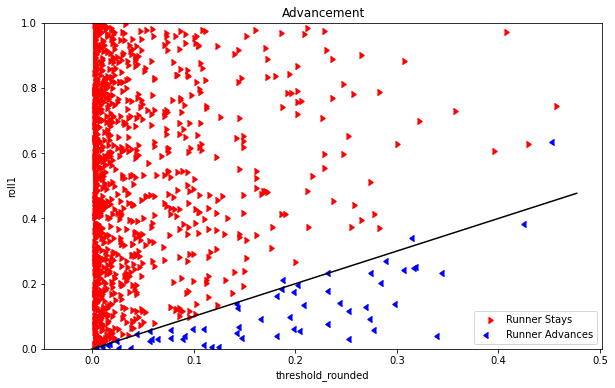

In [2848]:
# Manual threshold
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)
dfc["threshold_rounded"] = 0 + 0.125 * dfc["runner_on_first_indulgence_with_vibe_pow"]
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


3 outliers


,passed,roll1,threshold_rounded,event_type,inning,ballpark_mysticism,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
9896,True,0.635641,0.454411,flyout,5,0.5,Beck Whitney,NaN,LIFE_OF_PARTY;ELECTRIC,Fitzgerald Blackburn,NaN,Jordan Hildebert,FRIEND_OF_CROWS;SIPHON,NaN,12,59,71c9496b-b22e-4c76-8ff4-762e10f6ec3c,238
10616,True,0.211741,0.189805,flyout,6,0.5,Fran Beans,SWIM_BLADDER,NaN,Lance Serotonin,NaN,Grollis Zephyr,NaN,NaN,12,68,8a8b63bf-2e36-44e4-b807-a9c6879d81cc,256
10773,True,0.341339,0.316879,flyout,7,0.5,Valentine Games,NaN,NaN,Caleb Novak,FIRE_EATER,Qais Dogwalker,FRIEND_OF_CROWS,LIFE_OF_PARTY;ELECTRIC,12,70,85d00119-0076-462e-ab0c-ba201d727827,242


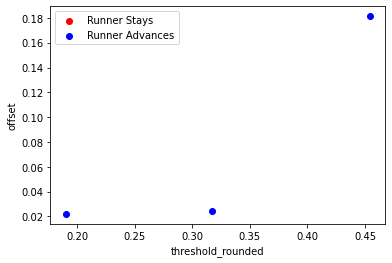

In [2849]:
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "ballpark_mysticism",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

In [2850]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[0]"]
print(len(dfc))

# Make thresholds
dfc["threshold_advance_first"] = -0.25 + 0.40 * dfc["runner_on_first_indulgence_with_vibe"]
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_advance_first"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "roll1",
        "threshold_advance_first",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

1033
True     1028
False       5
Name: guess, dtype: int64


,roll1,threshold_advance_first,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
1705,0.106581,0.125238,flyout,2,Alexander Horne,NaN,LOVE,Greer Gwiffin,NaN,Goodwin Morin,NaN,NaN,11,53,ce5cad0e-2935-43b9-8f1e-8d54b858a6f3,82
1746,0.100590,0.107043,flyout,7,Summers Pony,NaN,NaN,Kichiro Guerra,ALTERNATE,Yeong-Ho Garcia,ALTERNATE;FRIEND_OF_CROWS,LOVE,11,53,ce5cad0e-2935-43b9-8f1e-8d54b858a6f3,272
7971,0.133615,0.146200,flyout,1,Andrew Solis,FIRE_EATER,BIRD_SEED,Fish Summer,FIRE_EATER,Jenkins Good,ALTERNATE;FRIEND_OF_CROWS,EARLBIRDS,12,37,fbb58814-ecba-4337-add2-d77b26c7c11d,38
9051,0.098669,0.118906,flyout,5,Cannonball Sports,NaN,LIFE_OF_PARTY;ELECTRIC,Malik Romayne,NaN,Jordan Hildebert,FRIEND_OF_CROWS;SIPHON,NaN,12,49,90153b07-901a-490c-820e-037b1ba9d1ab,221
10418,0.115745,0.118213,flyout,2,Ziwa Mueller,NaN,EARLBIRDS,Marco Stink,NaN,Oscar Vaughan,ALTERNATE,NaN,12,66,d13d2891-62b8-4994-8e89-6a499ee4d823,99


### [0] -> [1]
DP (fail), Martyr (pass), ??? (unused)

In [2851]:
# # Define selection based on initial runners
# # Baserunners are a string, not list, because pandas doesn't like lists.
# dfc = df[df['baserunners'] == "[0]"]
# # Define the final state runners as well
# dfc = dfc[dfc['baserunners_next'] == "[1]"]
# print(len(dfc))

# # Make thresholds


# dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# # Prove what we think is correct
# dfc["guess"] = dfc["threshold_advance_second"]
# print(dfc["guess"].value_counts()) # If all True, we're right.

# # Plot unused rolls
# # fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# # ax.hist(
# #     dfc['roll3'],
# #     bins=10,
# #     range=[0.,1.],
# #     color="green",
# #     alpha = 0.5
# # )

# # Print Outliers
# outliers = dfc[~dfc["guess"]]
# n_outliers += len(outliers)
# outliers[
#     [
#         "roll1",
#         "event_type",
#         "inning",
#         "batter_name",
#         "batter_mods",
#         "batting_team_mods",
#         "fielder_name",
#         "fielder_mods",
#         "pitcher_name",
#         "pitcher_mods",
#         "pitching_team_mods",
#         "season",
#         "day",
#         "game_id",
#         "play_count",
#     ]
# ]

## Runner on Second

### [1] -> [1]
DP (unused), Advance (fail)

In [2852]:
dfc = df[df['baserunners'] == "[1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'].isin(["[1]","[2]"])]
print(len(dfc[~dfc['roll2'].isna()]))
dfc["passed"] = dfc['baserunners_next'].str.contains("[2]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
dfc['roll1'] = dfc['roll1'].apply(lambda x: x)
dfc['roll1_log'] = dfc['roll1'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_log'] = dfc['runner_on_second_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_pow'] = dfc['runner_on_second_indulgence_with_vibe']**3.5
X = dfc[
    [
        "roll1_log",
        "passed",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_second_indulgence_with_vibe_log',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

0


,roll1_log,runner_on_second_indulgence_with_vibe_log
38,-1.667431,-0.622512
54,-0.264770,-0.143494
89,-0.450116,-0.039090
194,-0.385823,0.081965
196,-0.933737,0.081965
...,...,...
10723,-2.458310,-0.533927
10733,-3.492190,-0.728494
10809,-0.263318,-1.737584
10815,-0.993252,-0.408070


In [2853]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)    

#trainedsvm = svm.LinearSVC(intercept_scaling=1000, dual=False, max_iter=100000, C=1000, class_weight="balanced").fit(
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[270   5]
 [  8 100]]
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       275
        True       0.95      0.93      0.94       108

    accuracy                           0.97       383
   macro avg       0.96      0.95      0.96       383
weighted avg       0.97      0.97      0.97       383

0.9660574412532638


In [2854]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[0.9740383]


[(1.0, 'roll1_log'),
 (-0.8953319530346887, 'runner_on_second_indulgence_with_vibe_log')]

15 outliers


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
6376,-0.058822,False,0.198537,0.257359,flyout,3,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,Son Scotch,NaN,Marco Escobar,NaN,NaN,12,17,79695922-d746-46e4-bc5f-ce821acb1fca,130
2477,-0.055451,False,0.221179,0.276630,flyout,6,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,Mcdowell Mason,NaN,Peanut Bong,HONEY_ROASTED,NaN,11,65,dc78518b-61d3-4f3c-8af1-7979513aae76,333
9491,-0.051014,False,0.342657,0.393671,flyout,8,NaN,NaN,NaN,Siobhan Chark,SWIM_BLADDER,Ankle Halifax,TRIPLE_THREAT,UNDERSEA,12,54,9e3e4bdd-2ef1-46c2-9a4c-6f0b47775832,315
884,-0.037749,False,0.307163,0.344912,flyout,6,NaN,NaN,NaN,Mcdowell Mason,NaN,Peanut Bong,HONEY_ROASTED,NaN,11,41,40d97855-3496-46e0-b9a4-bd14d62f7e29,227
422,-0.030190,False,0.349040,0.379230,flyout,2,NaN,NaN,NaN,Schneider Bendie,NaN,Alejandro Leaf,HONEY_ROASTED;TRIPLE_THREAT,BIRD_SEED,11,35,847b4816-19c6-4376-b0ed-73114b36322e,86
38,-0.029566,False,0.188731,0.218297,flyout,4,NaN,NaN,NaN,Sparks Beans,NaN,Arturo Huerta,TRIPLE_THREAT,NaN,11,30,08f2076e-cd82-47e1-9621-3e21ead98748,157
10308,-0.020023,False,0.181432,0.201455,flyout,8,NaN,NaN,BASE_INSTINCTS,Theodore Holloway,NaN,Jordan Hildebert,FRIEND_OF_CROWS;SIPHON,NaN,12,64,f4523506-3d93-4d99-ad51-aad019f47e8d,350
1016,-0.019377,False,0.429037,0.448414,flyout,6,NaN,NaN,NaN,Oliver Notarobot,ALTERNATE,Tot Clark,NaN,NaN,11,43,2d0595bf-4221-43c3-bf4a-9107dbf69bbd,219
10223,-0.010418,False,0.367220,0.377638,flyout,9,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,Socks Maybe,NaN,Rivers Rosa,TRIPLE_THREAT,LATE_TO_PARTY,12,63,dbbb9858-58f7-44d9-966c-4dc068aa88fa,276
988,-0.009831,False,0.280139,0.289970,flyout,3,NaN,NaN,BIRD_SEED,Alexander Horne,NaN,Sandford Garner,NaN,LOVE,11,43,05fe4b2e-74db-43fc-ac7b-af3f01f81a15,73


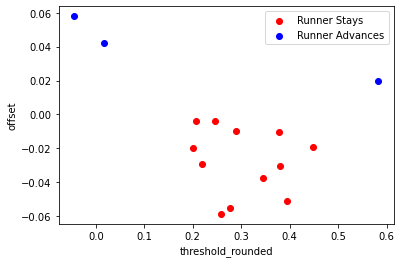

In [2855]:
dfc["threshold_rounded"] = -0.05 + 0.50 * dfc['runner_on_second_indulgence_with_vibe']

dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

[-0.9740383]
(0.8953319530346887, 'runner_on_second_indulgence_with_vibe_log')


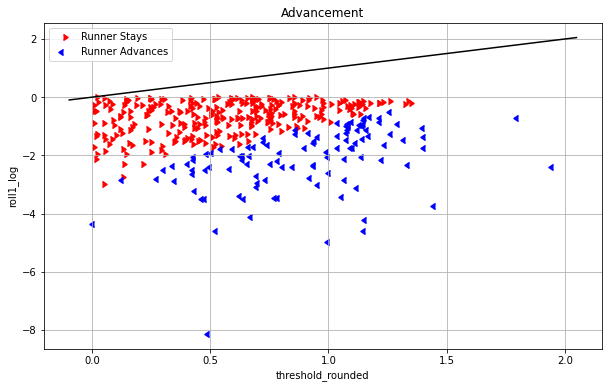

In [2856]:
# Manual threshold
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)
dfc["threshold_rounded"] = 1.5*dfc["runner_on_second_indulgence_with_vibe_log"]
dfc["threshold_rounded"] = dfc["runner_on_second_indulgence_with_vibe"]
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1_log":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.scatter(
#     dfc[~dfc["passed"]][x_val],
#     dfc[~dfc["passed"]]["roll1"],
#     color="red",
#     label="Runner Stays",
#     marker=CARETRIGHTBASE,
# )
# ax.scatter(
#     dfc[dfc["passed"]][x_val],
#     dfc[dfc["passed"]]["roll1"],
    
#     color="blue",
#     label="Runner Advances",
#     marker=CARETLEFTBASE,
# )
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1_log"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1_log"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1_log")
ax.set_title("Advancement")
ax.grid()
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


275
False    275
Name: guess, dtype: int64


,passed,threshold_advance_second,roll1,event_type,inning,runner_on_second_name,runner_on_second_mods,batting_team_mods,fielder_name,fielder_mods,pitching_team_mods,season,day,game_id,play_count
38,False,0.663606,0.188731,flyout,4,Allison Abbott,NaN,NaN,Sparks Beans,NaN,NaN,11,30,08f2076e-cd82-47e1-9621-3e21ead98748,157
54,False,0.761767,0.767382,flyout,6,Steph Weeks,FIRE_EATER,NaN,Aldon Cashmoney,SPICY,FIREPROOF;SEALANT,11,30,2e0c3967-b809-4874-96a1-23e47ced5082,207
89,False,0.803464,0.637554,flyout,0,Hahn Fox,NaN,BASE_INSTINCTS,Basilio Fig,FIRE_EATER,NaN,11,31,c35b29a6-2cd3-46a6-ace1-ae4d9ea015fb,21
194,False,0.795351,0.679891,flyout,1,Hendricks Richardson,NaN,BASE_INSTINCTS,Mcdowell Mason,NaN,NaN,11,32,0d41bbf7-cd57-4b1f-a74b-89220e4e855c,97
208,False,0.716713,0.990311,flyout,4,Oliver Notarobot,ALTERNATE,NaN,Sam Scandal,NaN,NaN,11,32,56f56b93-7440-4877-b0d5-f6a88b20b436,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10590,False,0.407788,0.775332,flyout,3,Cantus Hojo,NaN,BOTTOM_DWELLER;PARTY_TIME,Beck Whitney,NaN,LIFE_OF_PARTY;ELECTRIC,12,68,2aa6de78-e0fb-4c47-8807-b844e2f95c24,174
10634,False,0.645597,0.909948,flyout,0,Swamuel Mora,NaN,LATE_TO_PARTY,Sigmund Castillo,NaN,BASE_INSTINCTS,12,69,a69136ef-69df-4945-ae87-c8160fda4891,18
10809,False,0.549441,0.768497,flyout,1,Richmond Harrison,SIPHON,FIREPROOF;SEALANT;AMBUSH,Lance Serotonin,NaN,NaN,12,71,afe4226d-7574-4a24-8612-2bd90dae2245,62
10815,False,0.723429,0.370370,flyout,3,Eduardo Woodman,NaN,AFFINITY_FOR_CROWS,Theodore Duende,SPICY,NaN,12,71,367c06c1-a4f2-4084-aeb9-22b23e30074a,107


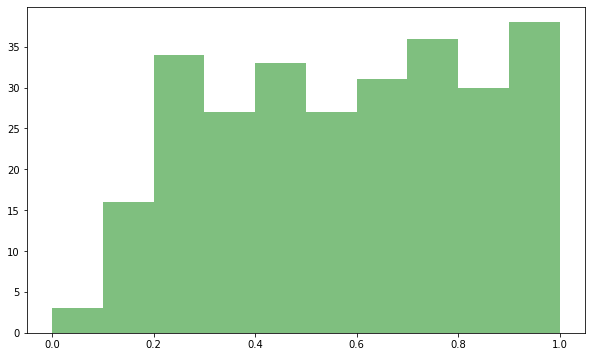

In [2857]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_second"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "passed",
        "threshold_advance_second",
        "roll1",
        "event_type",
        "inning",
        "runner_on_second_name",
        "runner_on_second_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [1] -> [2]
DP (unused), Advance (pass)

In [2858]:
# # Define selection based on initial runners
# # Baserunners are a string, not list, because pandas doesn't like lists.
# dfc = df[df['baserunners'] == "[1]"]
# # Define the final state runners as well
# dfc = dfc[dfc['baserunners_next'] == "[2]"]
# print(len(dfc))

# # Make thresholds


# dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
# dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# # Prove what we think is correct
# dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_second"])
# print(dfc["guess"].value_counts()) # If all True, we're right.

# # Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll1'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# # Print Outliers
# outliers = dfc[~dfc["guess"]]
# n_outliers += len(outliers)
# outliers[
#     [
#         "threshold_advance_second",
#         "roll2",
#         "event_type",
#         "inning",
#         "batter_name",
#         "batter_mods",
#         "batting_team_mods",
#         "fielder_name",
#         "fielder_mods",
#         "pitcher_name",
#         "pitcher_mods",
#         "pitching_team_mods",
#         "season",
#         "day",
#         "game_id",
#         "play_count",
#     ]
# ]

## Runner on Third

### [2] -> []
DP (unused), Advance (pass)

In [2859]:
dfc = df[df['baserunners'] == "[2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'].isin(["[2]","[]"])]
dfc["passed"] = ~dfc['baserunners_next'].str.contains("[2]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
X = dfc[
    [
        "roll1",
        "passed",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_third_indulgence_with_vibe',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

,roll1,runner_on_third_indulgence_with_vibe
12,0.596690,0.546263
52,0.222176,0.161536
94,0.042973,0.404583
112,0.297921,0.961664
130,0.119799,0.547959
...,...,...
10661,0.059249,0.219444
10681,0.649591,0.875153
10684,0.987395,1.244756
10689,0.855701,0.742316


In [2860]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)    

#trainedsvm = svm.LinearSVC(intercept_scaling=1000, dual=False, max_iter=100000, C=1000, class_weight="balanced").fit(
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[ 70   0]
 [  0 163]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        70
        True       1.00      1.00      1.00       163

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233

1.0


In [2861]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.46820482]


[(1.0, 'roll1'), (-0.3147944711989516, 'runner_on_third_indulgence_with_vibe')]

2 outliers


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
1510,-0.018569,False,0.642020,0.660589,flyout,3,NaN,NaN,NaN,Isaac Johnson,SIPHON,Edric Tosser,ALTERNATE,NaN,11,50,fb391e49-ce34-44d2-842e-4e85e62dca26,133
3079,-0.010567,False,0.582252,0.592820,flyout,5,NaN,NaN,NaN,Comfort Septemberish,NaN,Jordan Hildebert,FRIEND_OF_CROWS;SIPHON,NaN,11,74,c4fb024a-6947-40df-aed7-d754ad50aa59,218


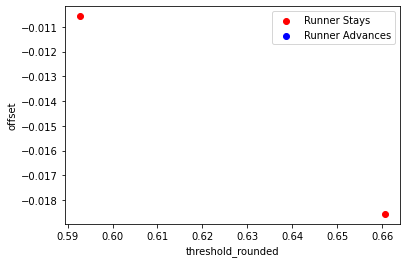

In [2862]:
dfc["threshold_rounded"] = 0.50 + 0.30 * dfc['runner_on_third_indulgence_with_vibe']

dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

[0.46820482]
(0.3147944711989516, 'runner_on_third_indulgence_with_vibe')


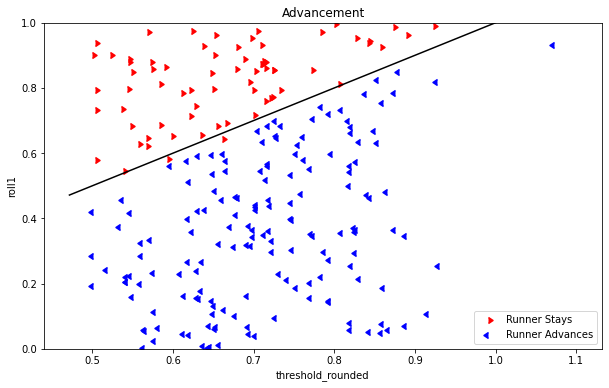

In [2863]:
# Manual threshold
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)
# dfc["threshold_rounded"] = -0.25 + 0.40 * dfc["runner_on_second_indulgence_with_vibe"]
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


### [2] -> [2]
DP (unused), Advance (fail)

70
False    70
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
173,0.450478,NaN,flyout,1,Son Scotch,NaN,NaN,Lou Roseheart,TRIPLE_THREAT,Caleb Alvarado,FRIEND_OF_CROWS,NaN,11,32,5bedd86b-0d5f-4397-90e8-c91f1d83510a,41
200,0.487411,NaN,flyout,2,Patel Beyonce,HONEY_ROASTED,NaN,Malik Destiny,ALTERNATE;FIRE_EATER,Goodwin Morin,NaN,NaN,11,32,56f56b93-7440-4877-b0d5-f6a88b20b436,112
340,0.464990,NaN,flyout,2,Joshua Butt,NaN,NaN,Kathy Mathews,ALTERNATE,Campos Arias,ALTERNATE,NaN,11,34,7cf47aaf-bb8c-4433-9ed4-7c4705572185,75
497,0.429175,NaN,flyout,3,Lawrence Horne,NaN,NaN,Conrad Vaughan,NaN,Combs Estes,SIPHON,NaN,11,36,0cb63eb3-b631-42aa-b0ac-0107fce96a1b,109
666,0.443452,NaN,flyout,7,Halexandrey Walton,SIPHON;PERK,NaN,Justice Spoon,ALTERNATE;FIRE_EATER,Rivers Rosa,NaN,NaN,11,38,758f5661-767f-4c16-959d-1858ad2f5265,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10432,0.487550,NaN,flyout,4,Goobie Ballson,NaN,LATE_TO_PARTY,Siobhan Chark,SWIM_BLADDER,Frankie Hambone,NaN,UNDERSEA,12,66,03690451-2dc4-4237-bbd2-3b75f02b152a,142
10503,0.402416,NaN,flyout,2,Helga Washington,NaN,NaN,York Silk,DOUBLE_PAYOUTS;HONEY_ROASTED,Jenkins Good,ALTERNATE;FRIEND_OF_CROWS,EARLBIRDS,12,67,528e1cea-e64e-4068-822c-f495f707a3b4,96
10529,0.400702,NaN,flyout,5,Halexandrey Walton,SIPHON;PERK,NaN,Dudley Mueller,SIPHON,Eugenia Bickle,ALTERNATE,BASE_INSTINCTS,12,67,5fe7aa8a-f841-474d-a45f-b9178a1656e0,221
10684,0.435845,NaN,flyout,5,Fitzgerald Blackburn,NaN,NaN,Collins Melon,ALTERNATE,Edric Tosser,ALTERNATE,EXTRA_STRIKE,12,69,a857b280-95b3-49c4-a136-85317e19605e,202


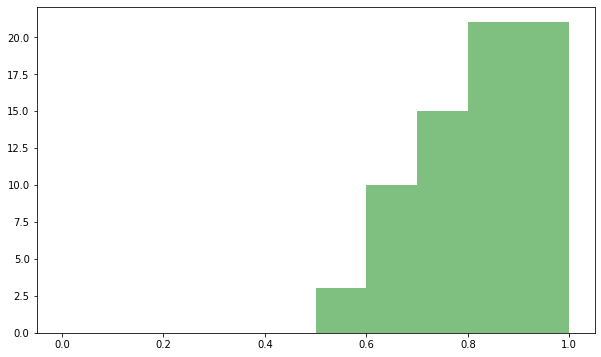

In [2864]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Runners on First and Second

### [1, 0] -> [1, 0]
DP (fail), Marytr (fail)

In [2865]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

144


KeyError: 'threshold_dp'

### [1, 0] -> [2, 1]
DP (fail), Marytr (pass), ???, ???. Last two are maybe fake advancement rolls

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll3'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll4'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

0
Series([], Name: guess, dtype: int64)


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


### [1, 0] -> [2, 0]
DP (fail), Marytr (pass), ???, ???. Last two are maybe fake advancement rolls

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll3'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll4'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

79
False    79
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
311,0.803661,NaN,flyout,6,Steph Weeks,FIRE_EATER,NaN,Lou Roseheart,TRIPLE_THREAT,Rivers Rosa,NaN,NaN,11,33,10fee55a-ef54-488e-86c7-e8b765a7bfca,247
640,0.673227,NaN,flyout,3,Lachlan Shelton,NaN,NaN,Oliver Notarobot,ALTERNATE,Durham Spaceman,NaN,NaN,11,38,8bbfff93-4366-4b6d-94ec-9e953674a084,147
880,0.838227,NaN,flyout,6,Steph Weeks,FIRE_EATER,NaN,Juice Collins,NaN,Stevenson Heat,ALTERNATE;FRIEND_OF_CROWS,NaN,11,41,55987fc2-0db1-41cc-9dd8-529fb57de1e3,201
1006,0.784623,NaN,flyout,5,Commissioner Vapor,PERK,NaN,Summers Pony,NaN,Tot Clark,NaN,NaN,11,43,2d0595bf-4221-43c3-bf4a-9107dbf69bbd,184
1762,0.779801,NaN,flyout,0,Commissioner Vapor,PERK,NaN,Helga Washington,NaN,Winnie Hess,SIPHON,NaN,11,54,9e310446-ff6c-466f-8130-df17e774f861,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26025,0.626409,NaN,flyout,12,Wichita Toaster,NaN,NaN,Kaz Fiasco,NaN,Ephraim Ladd,NaN,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,14,75,6dbfc62a-2258-467e-88cd-a6101c061f92,424
26359,0.749141,NaN,flyout,1,Bauer Zimmerman,NaN,NaN,Jan Canberra,NaN,Flattery McKinley,ALTERNATE,UNDERSEA,14,80,24a4c7bc-871a-46da-9119-27d05e661dd0,52
27270,0.572352,NaN,flyout,1,Quack Enjoyable,NaN,PARTY_TIME,Adelaide Judochop,NaN,Torus McGhee,NaN,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS;PARTY_TIME,14,91,777a6795-a926-4157-a768-d2fdb3dfd8d4,80
27369,0.769148,NaN,flyout,2,Yeong-Ho Garcia,ALTERNATE;FRIEND_OF_CROWS,PARTY_TIME,Caleb Novak,FIRE_EATER,Sixpack Santiago,NaN,LIFE_OF_PARTY;ELECTRIC,14,92,7e73de17-30c2-4245-bbbe-7919ad0b971f,120


## Runners on First and Third

### [2, 0] -> [0]
DP (fail), Martyr (pass), 3rd Advance (pass), 1st Advance (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[(df['baserunners'] == "[2, 0]")]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

190
False    163
True      27
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
110,0.483126,0.710537,flyout,2,Greer Gwiffin,NaN,NaN,Sam Scandal,NaN,Orville Manco,NaN,NaN,11,31,b8300d58-b47f-435e-a5c1-c43fb4ce197a,86
189,0.471524,0.792285,flyout,2,Comfort Septemberish,NaN,NaN,Goobie Ballson,NaN,Caleb Alvarado,FRIEND_OF_CROWS,NaN,11,32,5bedd86b-0d5f-4397-90e8-c91f1d83510a,81
414,0.474788,0.853803,flyout,1,Schneider Bendie,NaN,BIRD_SEED,Oliver Mueller,NaN,Betsy Trombone,ALTERNATE;FRIEND_OF_CROWS,NaN,11,35,847b4816-19c6-4376-b0ed-73114b36322e,42
842,0.485896,0.406760,flyout,11,Stijn Strongbody,NaN,NaN,Beasley Day,NaN,Henry Marshallow,NaN,AFFINITY_FOR_CROWS,11,40,e5b5ca21-7bd6-4816-85f0-18cd7888a017,406
1081,0.412584,0.922255,flyout,5,Kline Greenlemon,NaN,NaN,Alyssa Harrell,ALTERNATE,Evelton McBlase,NaN,NaN,11,44,f4b79d51-380f-48bb-9d12-434fd81a7739,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27113,0.429047,0.637047,flyout,3,Quack Enjoyable,NaN,PARTY_TIME,Conner Haley,SPICY,Leach Herman,ALTERNATE;FRIEND_OF_CROWS,NaN,14,89,ea4a64d4-921f-4f5a-95e7-ffd805ee0c89,140
27142,0.464674,0.384575,flyout,6,Baby Doyle,PERK,NaN,Summers Preston,NaN,Silvia Rugrat,SIPHON,NaN,14,89,87d828cb-52ee-4c6d-a2da-9ccb4108110b,218
27578,0.453815,0.936830,flyout,7,Francisca Sasquatch,HONEY_ROASTED,LIFE_OF_PARTY;ELECTRIC,Kaz Fiasco,NaN,Patchwork Southwick,NaN,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS;PARTY_TIME,14,94,0e238eb4-9a66-4849-970e-b539a65ea4c2,290
27602,0.482820,0.763380,flyout,1,Eduardo Woodman,NaN,AFFINITY_FOR_CROWS;PARTY_TIME,Baldwin Breadwinner,NaN,Montgomery Bullock,FRIEND_OF_CROWS;WILD,SINKING_SHIP;PARTY_TIME,14,95,6089571b-6a64-437b-9249-46febb5c6329,65


### [2, 0] -> [1]
DP (fail), Martyr (pass), 3rd Advance (pass), 1st Advance (pass)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

8
True     4
False    4
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
10769,0.468333,0.317001,flyout,6,Fitzgerald Blackburn,NaN,NaN,Steph Weeks,FIRE_EATER,Walton Sports,FRIEND_OF_CROWS,EXTRA_STRIKE,12,70,9cf741ff-186e-44ec-9f3c-29e22936a7f0,235
10962,0.436664,0.166993,flyout,12,Kline Greenlemon,NaN,NaN,Grey Alvarado,REPEATING,Mooney Doctor II,ALTERNATE;FRIEND_OF_CROWS,NaN,12,72,75817981-40c0-4755-a738-0abaa33fc781,467
14902,0.434858,0.073107,flyout,9,Liquid Friend,HARD_BOILED,LOVE,Dickerson Morse,NaN,Ronan Jaylee,NaN,NaN,13,23,7aa92e81-e5a1-48ba-9739-62bdf316ddc0,342
26338,0.474335,0.339526,flyout,6,Logan Horseman,NaN,LIFE_OF_PARTY;ELECTRIC,Goobie Ballson,NaN,Agan Harrison,NaN,NaN,14,79,2537d176-b250-492e-9912-f783ba61a704,260


### [2, 0] -> [2, 1]
DP (fail), Martyr (pass), 3rd Advance (fail), ??? (unused). Last one is maybe fake advancement roll

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc['roll4'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_dp",
        "roll1",
        "threshold_martyr",
        "roll2",
        # "threshold_advance_third",
        # "roll3",
        "event_type",
        "inning",
        # "batter_name",
        # "batter_mods",
        "runner_on_third_name",
        "runner_on_third_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        # "pitcher_name",
        # "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

0
Series([], Name: guess, dtype: int64)


,threshold_dp,roll1,threshold_martyr,roll2,event_type,inning,runner_on_third_name,runner_on_third_mods,batting_team_mods,fielder_name,fielder_mods,pitching_team_mods,season,day,game_id,play_count


## Runners on Second and Third

### [2, 1] -> [1]
DP (unused), 3rd Advance (pass), 2nd Advance (fail)

53
True     27
False    26
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
776,0.588097,0.815284,flyout,0,Cannonball Sports,NaN,LIFE_OF_PARTY;ELECTRIC,Alexander Horne,NaN,Percival Wheeler,NaN,LOVE,11,40,da148b18-4aa8-4497-8dea-8bd125f64e0a,43
2010,0.750109,0.839264,flyout,6,Goobie Ballson,NaN,NaN,Elwin McGhee,NaN,Coolname Galvanic,NaN,NaN,11,57,3e5500f6-67f7-4302-ab43-67178a25f154,187
3194,0.505874,0.947629,flyout,1,Joshua Watson,ALTERNATE,NaN,Elwin McGhee,NaN,Val Hitherto,NaN,NaN,11,76,b154c05e-c384-43a8-840d-9c5270d79295,41
3317,0.595672,0.748731,flyout,7,Knight Triumphant,SIPHON;PERK,LOVE,Stew Briggs,REPEATING,Mooney Doctor II,ALTERNATE;FRIEND_OF_CROWS,NaN,11,77,804712d3-f3bc-4620-b145-0e2fad5ce50e,235
5065,0.489998,0.716979,flyout,5,Halexandrey Walton,SIPHON;PERK,NaN,Dudley Mueller,SIPHON,Eugenia Bickle,ALTERNATE,BASE_INSTINCTS,12,2,035c7cca-b9ea-4e6a-97df-b7564da2df41,205
7907,0.503785,0.499204,flyout,2,Mint Shupe,NaN,UNDERSEA,Augusta Chadwell,NaN,Wanda Schenn,NaN,BOTTOM_DWELLER,12,36,18d3b906-4be0-4f0d-bf6e-6767afed1d74,99
8975,0.516621,0.584202,flyout,6,Siobhan Chark,SWIM_BLADDER,UNDERSEA,Kathy Mathews,ALTERNATE,Combs Estes,SIPHON,EXTRA_STRIKE,12,48,fe8cae32-068f-4b77-a100-ed86a6f06d1d,374
9365,0.524895,0.882132,flyout,3,Don Mitchell,REVERBERATING,LOVE;EXTRA_STRIKE;BASE_DEALING,Thomas Dracaena,NaN,Felix Garbage,NaN,BIRD_SEED,12,53,9161223c-4fd5-447e-a3bd-54745a6e6122,162
9824,0.906835,0.941043,flyout,8,Fitzgerald Blackburn,NaN,NaN,Caleb Novak,FIRE_EATER,Qais Dogwalker,FRIEND_OF_CROWS,LIFE_OF_PARTY;ELECTRIC,12,58,e348e241-29c4-4dc0-9ff1-563e80766284,323
10725,0.674919,0.783333,flyout,1,Cory Ross,SIPHON,NaN,Helga Burton,NaN,Percival Wheeler,NaN,LOVE;EXTRA_STRIKE;BASE_DEALING,12,70,43f060f2-9dc6-46d5-8c72-b22e744598f7,55


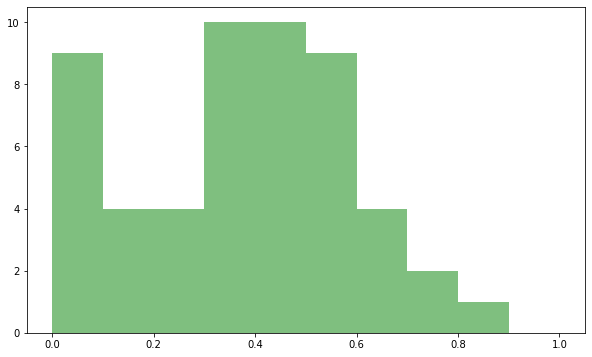

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1] -> [2]
DP (unused), 3rd Advance (pass), 2nd Advance (pass)

21
True     19
False     2
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
10460,1.134172,0.797068,flyout,7,Malik Destiny,ALTERNATE;FIRE_EATER,NaN,Gia Holbrook,NaN,Torus McGhee,NaN,MAINTENANCE_MODE,12,66,8f2922f6-1a23-4bf2-bb4b-37543fd406f2,245
14293,0.937045,0.697295,flyout,0,Igneus Delacruz,ALTERNATE;CHUNKY,BASE_INSTINCTS,Kaz Fiasco,NaN,NaN,FLICKERING;RECEIVER,BOTTOM_DWELLER,13,16,4e50ff61-aef4-4738-9c61-b4199740437d,56


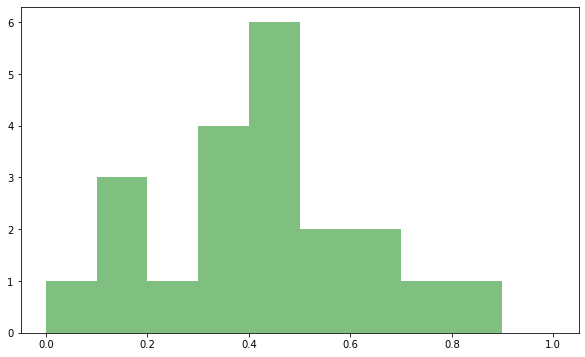

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1] -> [2, 1]
DP (unused), 3rd Advance (fail), 2nd Advance (fail)

38
False    38
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
334,0.711738,NaN,flyout,1,Kline Greenlemon,NaN,NaN,Alston Cerveza,NaN,Mooney Doctor,NaN,NaN,11,34,5e6303ab-db76-411c-a2e2-6697d3a3d590,54
930,0.645711,NaN,flyout,1,NaN,FLICKERING;RECEIVER,NaN,Rai Spliff,NaN,Kit Adamses,NaN,NaN,11,42,4ecec8a3-57de-49de-8098-5dd3d87739d5,87
999,0.637976,NaN,flyout,4,Fish Summer,FIRE_EATER,NaN,Theodore Duende,SPICY,Tot Clark,NaN,NaN,11,43,2d0595bf-4221-43c3-bf4a-9107dbf69bbd,149
4315,0.524783,NaN,flyout,8,Rodriguez Internet,ALTERNATE;FIRE_EATER;REPEATING,NaN,Jode Preston,NaN,Nicholas Mora,NaN,AFFINITY_FOR_CROWS,11,91,1daa0ad9-33d9-4817-922b-553c4e688b28,318
4443,0.669594,NaN,flyout,5,Theodore Duende,SPICY,NaN,Ziwa Mueller,NaN,Beasley Gloom,NaN,NaN,11,93,e584052d-2f65-4229-88fe-746705ac79e3,207
4607,0.506446,NaN,flyout,5,Peanutiel Duffy,HONEY_ROASTED,NaN,Randy Dennis,SIPHON,Wyatt Owens,NaN,LIFE_OF_PARTY;ELECTRIC;PARTY_TIME,11,95,728fe0a1-c35d-4603-a7cd-bc739e11e85c,247
4797,0.532211,NaN,flyout,4,Oliver Notarobot,ALTERNATE,NaN,Eizabeth Guerra,NaN,PolkaDot Zavala,NaN,PARTY_TIME,11,98,a828b147-2456-472d-b73f-13e0bd945893,142
5086,0.632341,NaN,flyout,9,Randy Dennis,SIPHON;SWIM_BLADDER,LIFE_OF_PARTY;ELECTRIC,Zion Aliciakeyes,SWIM_BLADDER,Dunlap Figueroa,NaN,FIREPROOF;SEALANT;AMBUSH,12,2,b918498c-4abb-4a80-a2e4-7002dc1d011a,296
5336,0.531016,NaN,flyout,7,Summers Preston,NaN,NaN,Isaac Johnson,SIPHON,Agan Harrison,NaN,LATE_TO_PARTY,12,5,ed480597-01bc-419a-8d63-036f00ae792d,238
6720,0.825274,NaN,flyout,5,Malik Romayne,NaN,NaN,Sigmund Castillo,NaN,Zack Sanders,NaN,BASE_INSTINCTS,12,21,d0b2b3c9-ae65-4f82-9179-8d457d7132fd,222


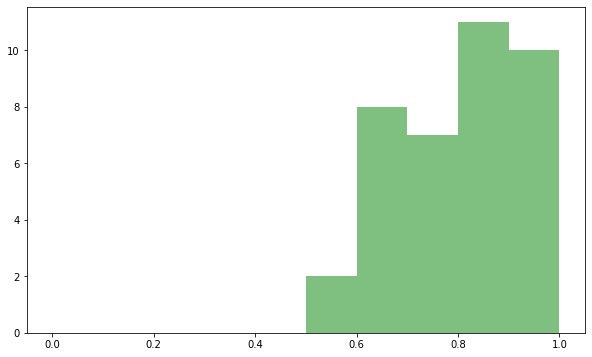

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1] -> [2, 2]
DP (unused), 3rd Advance (fail), 2nd Advance (pass)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"]) & (dfc["roll3"] < dfc["threshold_advance_second"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

0


KeyError: 'roll3'

## Runners Holding Hands on Third

### [2, 2] -> []
DP (unused), 3rd Advance (pass), 3rd hh Advance (pass)

8
True    8
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


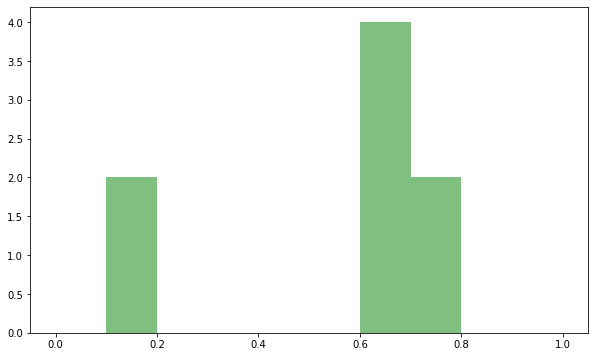

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"]) & (dfc["roll3"] < dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 2] -> [2]
DP (unused), 3rd Advance (fail), 3rd Advance hh (pass)
OR
DP (unused), 3rd Advance (pass), 3rd Advance hh (fail)
- We only have 3 examples of the former and none of the latter!

6
True    6
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


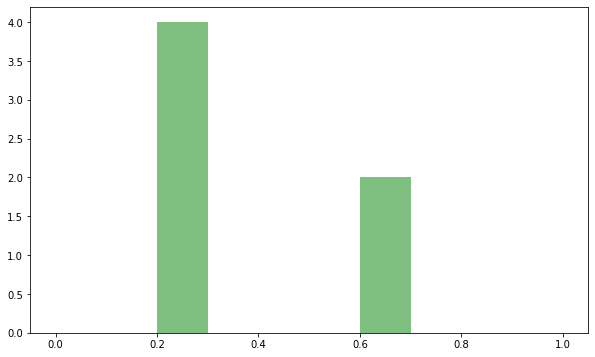

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"]) | (dfc["roll3"] < dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 2] -> [2, 2]
DP (unused), 3rd Advance (fail), 3rd Advance (fail)

3
True    3
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


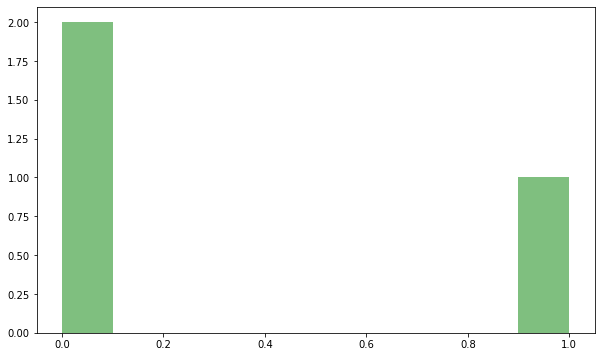

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"]) & (dfc["roll3"] > dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Bases Loaded

### [2, 1, 0] -> [2, 1] (five rolls)
DP (fail), Martyr (pass), ???, ???, ???. Last three are maybe fake advancment rolls

90
True    90
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


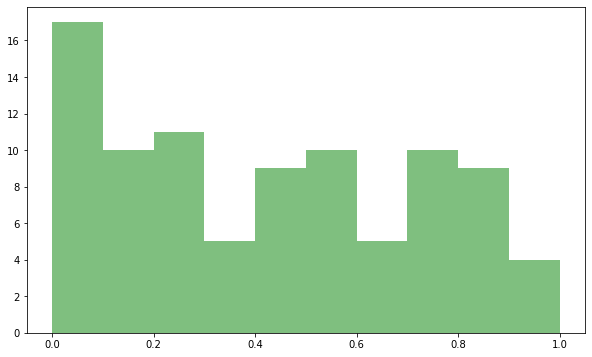

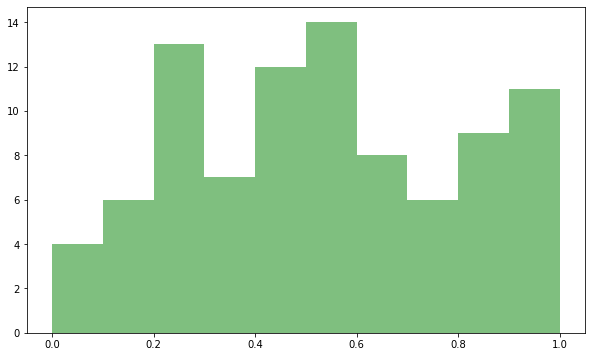

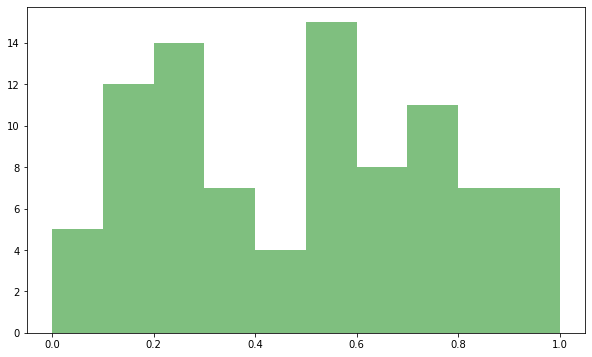

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[(df['baserunners'] == "[2, 1, 0]") & (~df['roll5'].isna())]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] < dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll3'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll4'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll5'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1, 0] -> [2, 1, 0]
DP (fail), Martyr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 1, 0] -> [1, 0]
DP (fail), Martyr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

320
True    320
Name: guess, dtype: int64


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


### [2, 1, 0] -> [2, 0]
DP (fail), Martyr (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 1, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Bases Overloaded

### [2, 1, 2, 0] -> [2, 0]
DP (fail), Martyr (fail), ???

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 1, 2, 0]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 0]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll1"] > dfc["threshold_dp"]) & (dfc["roll2"] > dfc["threshold_martyr"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

0
Series([], Name: guess, dtype: int64)


,threshold_advance_second,roll2,event_type,inning,batter_name,batter_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


In [ ]:
# How many outliers?
print(n_outliers)

3
